## Isentropic Vortex 

> WORK IN PROGRESS !!!

In this example we are going to solve the Euler equations for an isentropic two-dimensional vortex in a full-periodic square domain. Since the problem is not diffusive, the expected behavior is for the vortex to be convected unchanged forever. This is a useful example for testing the diffusive properties of our methods, as well as its numerical stability.

\begin{equation}
    \begin{array}{c}
        \rho_t + \nabla \cdot (\rho u) = 0 \\
        (\rho \mathbf{u})_t + (\mathbf{u} \cdot \nabla)(\rho \mathbf{u}) + \nabla p = 0 \\
        (\rho e)_t + \nabla \cdot(\mathbf{u} (  \rho e + p )) = 0
    \end{array}
\end{equation}

The inputs to the network will be the independent variables $x$, $y$ and $t$ and the outputs will be the conserved variables $\rho$, $\rho \mathbf{u}$ and $\rho e$ where $\rho$ is the density, $\mathbf{u} = (u, v)$ is the velocity and $e$ is the specific energy.

![](http://hypar.github.io/Solution_2DNavStokLowMachVortexPETSc.gif)

In [2]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

First we define our PDE and set the values for training.

In [4]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs, outputs, params):
        super().__init__(inputs, outputs, params)
    def computePDELoss(self, grads, inputs, outputs, params): 
        drdt = grads['r']['t']            
        r, u, v, p = outputs['r'], outputs['u'], outputs['v'], outputs['p']        
        ru = r*u
        drudx = self.computeGrad(ru, 'x')
        drudt = self.computeGrad(ru, 't')        
        rv = r*v
        drvdy = self.computeGrad(rv, 'y')
        drvdt = self.computeGrad(rv, 't')      
        ruup = r*u*u + p
        druupdx =  self.computeGrad(ruup, 'x')
        ruv = r*u*v
        druvdy =  self.computeGrad(ruv, 'y')        
        rvvp = r*v*v + p
        drvvpdy =  self.computeGrad(rvvp, 'y')
        rvu = r*v*u
        drvudx =  self.computeGrad(rvu, 'x')                                   
        re = p/(params['g']-1) + 0.5*r*(u*u + v*v)
        dredt = self.computeGrad(re, 't')
        repu = (re+p)*u
        drepudx = self.computeGrad(repu, 'x')
        repv = (re+p)*v
        drepvdy = self.computeGrad(repv, 'y')        
        return [
            drdt + drudx + drvdy,
            drudt + druupdx + druvdy,
            drvdt + drvudx + drvvpdy,
            dredt + drepudx + drepvdy
        ]

        
        
# instanciate pde
pde = MyPDE(inputs=['x', 'y', 't'], outputs=['r', 'u', 'v', 'p'], params=['g'])

# define input values
x = np.linspace(0,2,40)
y = np.linspace(-1,1,40)
t = np.linspace(0,0.5,20)

pde.setValues({'x': x, 'y': y, 't': t, 'g': np.array([1.4])})
pde.setValues({'x': x, 'y': y, 't': t}, train=False)

Boundary conditions.

In [5]:
# periodic b.c for the space dimension

x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_x', {'x': x1, 'y': y, 't': t}, {'x': x2, 'y':y, 't': t})
pde.addBoco(boco)

y1, y2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_y', {'x': x, 'y': y1, 't': t}, {'x': x, 'y':y2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
gamma, Ma = 1.4, 0.6
Rgas = 1./(gamma*Ma*Ma)
Rc, C = 0.2, -0.1   

r0 = np.zeros((len(y)*len(x)))
u0 = np.zeros((len(y)*len(x)))
v0 = np.zeros((len(y)*len(x)))
p0 = np.zeros((len(y)*len(x)))
for i, _y in enumerate(y):
    for j, _x in enumerate(x):
        # vortex center at (5, 5)
        x1, x2 = x[j] - 1, y[i]
        
        e = -(x1*x1+x2*x2)/(2.*Rc*Rc)
        
        ro = 1. 
        T = 1.
        p = ro*Rgas*T+ro*C*C/(Rc*Rc)*math.exp(e)
        u = 1.+C/ro*e*math.exp(e)*(-2.*x2/(2*Rc*Rc))
        v = 0.-C/ro*e*math.exp(e)*(-2.*x1/(2*Rc*Rc))
        
        r0[i*len(x) + j] = ro
        u0[i*len(x) + j] = u
        v0[i*len(x) + j] = v
        p0[i*len(x) + j] = p
        
boco = DirichletBoco('initial_condition', {'x': x, 'y': y, 't': np.array([0])}, {'r': r0, 'u': u0, 'v': v0, 'p': p0})
pde.addBoco(boco)

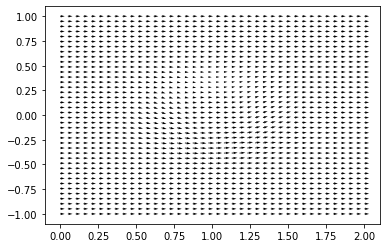

In [6]:
# visualize initial condition

fig, ax = plt.subplots()
u, v = u0.reshape(len(y),len(x)), v0.reshape(len(y),len(x))
q = ax.quiver(x, y, u, v)
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')
plt.show()

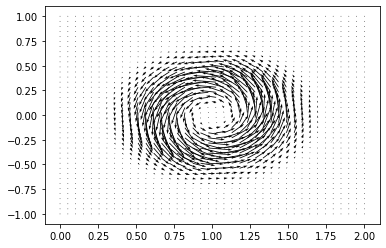

In [7]:
# removing free-streem velocity component

fig, ax = plt.subplots()
q = ax.quiver(x, y, u - 1, v)
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [8]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 4096)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

In [9]:
# find the solution
hist = pde.solve(epochs=20) 

/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


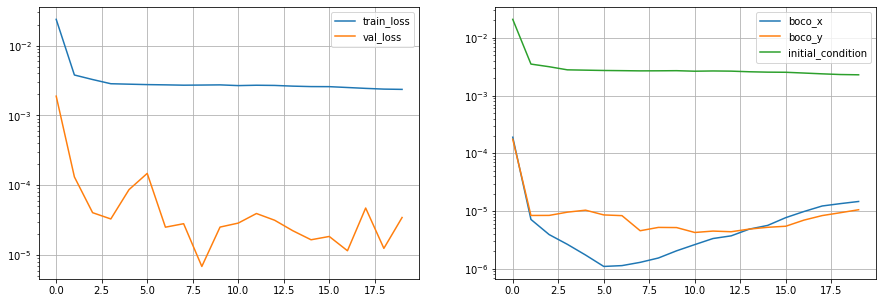

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

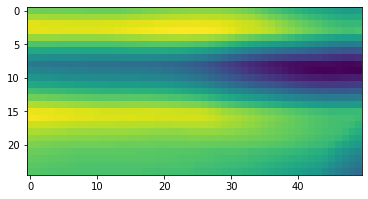

In [11]:
# evaluate the solution
x = np.linspace(0,2,50)
y = np.linspace(-1,1,25)
t = np.array([0.5])
pde.evaluate({'x': x, 'y': y, 't': t})
r = pde.outputs['r']
plt.imshow(r.reshape(len(y),len(x)))
plt.show()